# Total run time for notebook
On an M2 MacBook Pro it took approx. 12 seconds for a full run.

In [1]:
import pandas as pd
import numpy as np
import random
from IPython.display import display
from datetime import datetime

ranking_df = pd.read_csv('./datasets/fifa_ranking-2023-07-20.csv')
game_results_df = pd.read_csv('./datasets/results.csv')
rank_at_year_df = pd.read_csv('./datasets/rank_per_yr_T_sorted.csv')
rank_at_year_df.set_index('Country',inplace=True)

# Checking dataset info

In [2]:
ranking_df.info()
game_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64757 entries, 0 to 64756
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rank             64757 non-null  int64  
 1   country_full     64757 non-null  object 
 2   country_abrv     64757 non-null  object 
 3   total_points     64757 non-null  float64
 4   previous_points  64757 non-null  float64
 5   rank_change      64757 non-null  int64  
 6   confederation    64757 non-null  object 
 7   rank_date        64757 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 4.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45315 entries, 0 to 45314
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        45315 non-null  object
 1   home_team   45315 non-null  object
 2   away_team   45315 non-null  object
 3   home_score  45315 non-null  int64 
 4   away_score  45315

In [3]:
# Fixes the columns by converting year columns to int. If not possible convert to str.
def fix_col(column):
    try:
        new_val = int(column)
        return new_val
    except:
        return str(column)
rank_at_year_df.columns = rank_at_year_df.columns.map(lambda x: fix_col(x))
# Replace USA -> United States
rank_at_year_df.loc['United States',:] = rank_at_year_df.loc['USA'].copy()
rank_at_year_df.drop('USA',inplace=True,axis=0)
# Filter out games with teams not in the FIFA ranking
print('Before removal of unusable games:', game_results_df.shape)
game_results_df.loc[game_results_df['home_team'] == 'USA', 'home_team'] = 'United States'
game_results = game_results_df.loc[(game_results_df['home_team'].isin(values=rank_at_year_df.index.values)) & (
    game_results_df['away_team'].isin(values=rank_at_year_df.index.values))].copy()
print('After removal:', game_results.shape)
# Get rid of the City column - useless
game_results.drop(columns=['city'],inplace=True,axis=1)
game_results

Before removal of unusable games: (45315, 9)
After removal: (38842, 9)


,date,home_team,away_team,home_score,away_score,tournament,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Scotland,False
...,...,...,...,...,...,...,...,...
45310,2023-11-21,Wales,Turkey,1,1,UEFA Euro qualification,Wales,False
45311,2023-11-21,Croatia,Armenia,1,0,UEFA Euro qualification,Croatia,False
45312,2023-11-21,Andorra,Israel,0,2,UEFA Euro qualification,Andorra,False
45313,2023-11-21,Kosovo,Belarus,0,1,UEFA Euro qualification,Kosovo,False


In [4]:
# Encode the home team.
game_results['home_code'] = game_results.home_team.astype('category').cat.codes
l = len(game_results['home_team'].values)
# Using the home team encoding, create a dict for country:country_code
country_codes = {game_results['home_team'].values[i]:game_results['home_code'].values[i] for i in range(l)}
# Get the last code
code = max(country_codes.values()) + 1
# encode_dict = game_results.['home_team']
def encode_away_teams(x):
   global code
   val = country_codes.setdefault(x, code)
   if val == code:
      code+=1
   return val
# Now using values from home_code, encode away and hosting country. This ensures they are identical. I.e. if United States as a home team is coded 22, then it's
# 22 in away and hosting country.
game_results['away_code'] = game_results.away_team.apply(lambda x: encode_away_teams(x)).copy()
game_results['hosting_country_code'] = game_results.country.apply(lambda x: encode_away_teams(x)).copy()
game_results.head(5)

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,hosting_country_code
0,1872-11-30,Scotland,England,0,0,Friendly,Scotland,False,154,58,154
1,1873-03-08,England,Scotland,4,2,Friendly,England,False,58,154,58
2,1874-03-07,Scotland,England,2,1,Friendly,Scotland,False,154,58,154
3,1875-03-06,England,Scotland,2,2,Friendly,England,False,58,154,58
4,1876-03-04,Scotland,England,3,0,Friendly,Scotland,False,154,58,154


Since we only have fifa rankings starting from 1992-12-31, we'll be only keeping games from 1993-Present

In [5]:
# Convert dates to datetime
game_results['date'] = pd.to_datetime(game_results['date'],format='%Y-%m-%d')
ranking_df['rank_date'] = pd.to_datetime(ranking_df['rank_date'],format='%Y-%m-%d')
# Filter the games and rankings starting from 1993
game_results = game_results[game_results['date'] >= datetime(1993, 1, 1)].copy()
ranking_df = ranking_df[ranking_df['rank_date'] >= datetime(1993, 1, 1)].copy()
# Convert 'neutral' column to int
game_results['neutral'] = game_results['neutral'].astype(int)
# Display the 'neutral' column to verify the changes
game_results['neutral'].head()
game_results.tournament.value_counts()

tournament
Friendly                                8343
FIFA World Cup qualification            5421
UEFA Euro qualification                 1982
African Cup of Nations qualification    1234
UEFA Nations League                      472
                                        ... 
Three Nations Cup                          1
TIFOCO Tournament                          1
The Other Final                            1
Cup of Ancient Civilizations               1
Copa Confraternidad                        1
Name: count, Length: 88, dtype: int64

In [6]:
game_results.dtypes

date                    datetime64[ns]
home_team                       object
away_team                       object
home_score                       int64
away_score                       int64
tournament                      object
country                         object
neutral                          int64
home_code                        int16
away_code                        int16
hosting_country_code             int64
dtype: object

# Create a final_score column
Encodes the three values: 
- Home loss $\rightarrow0$
- Tie $\rightarrow1$
- Home win $\rightarrow2$

In [7]:
game_results['final_score'] = game_results.apply(lambda x: 2 if x.away_score < x.home_score else 0 if x.away_score > x.home_score else 1,axis=1)

# Drop the index

In [8]:
game_results.reset_index(level=0,inplace=True)
game_results.drop('index',inplace=True,axis=1)
game_results['final_score'].value_counts()

final_score
2    11375
0     6563
1     5610
Name: count, dtype: int64

# Plot the final_score values

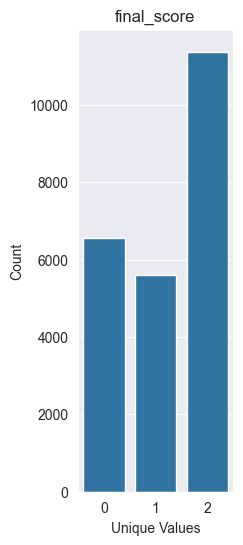

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(2, 6))
sns.countplot(x='final_score', data=game_results)
plt.title('final_score')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.show()

We have heavy data imbalance where there are more home wins are alot higher than losses or ties. We'll probably need to either undersample the wins or oversample the ties/losses.

In [10]:
game_results.tournament.value_counts()

tournament
Friendly                                8343
FIFA World Cup qualification            5421
UEFA Euro qualification                 1982
African Cup of Nations qualification    1234
UEFA Nations League                      472
                                        ... 
Three Nations Cup                          1
TIFOCO Tournament                          1
The Other Final                            1
Cup of Ancient Civilizations               1
Copa Confraternidad                        1
Name: count, Length: 88, dtype: int64

We need to limit the tournament categories to just three: 
- Cup
- Tournament
- Friendly

In [11]:
def decide_competition(match_type):
   # Superclasico is a south american friendly
   if match_type.lower() == 'friendly' or match_type.lower().find('superclásico') != -1:
      return 2
   tournament_names = ['tournoi','uefa','tournament','qualifications','qualification','games','festival','league']
   cup_names = ['cup', 'final','championship','copa']
   # Tournament - 0
   for x in tournament_names:
      if match_type.lower().find(x) != -1:
         return 0
   # Cup - 1
   for x in cup_names:
      if match_type.lower().find(x) != -1:
         return 1

### Reorganize the tournaments to either be a cup, tournament, or friendly
Encodes the three values: 
- Tournament $\rightarrow0$
- Cup $\rightarrow1$
- Friendly $\rightarrow2$

In [12]:
game_results['tournament_code'] = game_results['tournament'].apply(decide_competition)

In [13]:
game_results['tournament_code'] = game_results.tournament_code.astype(int)
game_results['tournament_code'].value_counts()
game_results

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,hosting_country_code,final_score,tournament_code
0,1993-01-01,Ghana,Mali,1,1,Friendly,Gabon,1,72,112,68,1,2
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Gabon,0,68,30,68,1,2
2,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait,0,97,100,97,2,2
3,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Gabon,1,30,112,68,2,2
4,1993-01-03,Gabon,Ghana,2,3,Friendly,Gabon,0,68,72,68,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23543,2023-11-21,Wales,Turkey,1,1,UEFA Euro qualification,Wales,0,195,183,195,1,0
23544,2023-11-21,Croatia,Armenia,1,0,UEFA Euro qualification,Croatia,0,45,9,45,2,0
23545,2023-11-21,Andorra,Israel,0,2,UEFA Euro qualification,Andorra,0,4,89,4,0,0
23546,2023-11-21,Kosovo,Belarus,0,1,UEFA Euro qualification,Kosovo,0,96,18,96,0,0


Seems like we have much more tournament matches. We might need to oversample cup games later if the results aren't good

### Test run..

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
test_me = False
if test_me:
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
    game_results_ready = game_results.drop(['home_team','away_team','home_score','away_score','tournament','country','date'],axis=1)
    X = game_results_ready.drop(['final_score'], axis=1)
    y = game_results_ready['final_score']
    X.info()
    # Splitting of Data - 70/30
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, stratify=y,  random_state=42)
    # svm = svm_ovo = SVC(decision_function_shape='ovo', kernel='linear')
    lr = GradientBoostingClassifier(n_estimators=100, random_state=42)
    # svm_ovo.fit(X_train, y_train)
    lr.fit(X_train,y_train)
    # y_pred_ovo = svm_ovo.predict(X_test)
    y_pred_lr = lr.predict(X_test)
    # accuracy_ovo = accuracy_score(y_test, y_pred_ovo)
    # f1_ovo = f1_score(y_test,y_pred_ovo,average='macro')
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    conf_mat = confusion_matrix(y_test,y_pred_lr)
    f1_lr = f1_score(y_test,y_pred_lr,average='macro')
    # print(f"Accuracy (One-vs-One): {accuracy_ovo}")
    # print(f'F1-Score: {f1_ovo}')
    print(f"Accuracy (Logistic Regression): {accuracy_lr}")
    print(f'F1-Score: {f1_lr}')
    
    accuracy = accuracy_score(y_test, y_pred_lr)
    print(f"Accuracy: {accuracy:.2f}")
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Plot a heatmap of the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=lr.classes_, yticklabels=lr.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

### Get the most recent FIFA rank at the time of match and get the difference in rank between the two teams
Negative value indicates that home team's rank is better than away team. Value itself shows how far apart they are.

In [15]:
game_results['most_recent_rank_home'] = game_results.apply(lambda x: rank_at_year_df.loc[x['home_team'],x['date'].year] ,axis=1)
game_results['most_recent_rank_away'] = game_results.apply(lambda x: rank_at_year_df.loc[x['away_team'],x['date'].year] ,axis=1)
# Calculate the ranking difference
game_results['most_recent_rank_difference'] = game_results['most_recent_rank_home'] - game_results['most_recent_rank_away']

game_results['home_advantage'] = 0
game_results.loc[game_results['home_code'] == game_results['hosting_country_code'], 'home_advantage'] = 1
game_results['home_advantage'].value_counts()

home_advantage
1    17702
0     5846
Name: count, dtype: int64

### Get FIFA points total at the time

In [16]:
game_results['home_fifa_pts'] = game_results.apply(lambda x: rank_at_year_df.loc[x['home_team'],'{}_points'.format(x['date'].year)], axis = 1)
game_results['away_fifa_pts'] = game_results.apply(lambda x: rank_at_year_df.loc[x['away_team'],'{}_points'.format(x['date'].year)], axis = 1)

### Now to check historical head-to-head matches between the two teams


In [17]:

# Define a function to calculate the number of wins for the home team against the away team in the last 5 matches
# This is too slow so we'll only use it for rows later
def calculate_head_to_head(row):
    home_team = row['home_team']
    away_team = row['away_team']
    
    # Extract the relevant subset of matches
    relevant_matches = game_results[((game_results['home_team'] == home_team) & (game_results['away_team'] == away_team))]
    
    # Consider only the last 5 matches
    last_5_matches = relevant_matches[relevant_matches['date'] < row['date']].tail(5)
    
    # Count the number of wins for the home team
    wins_home_team = last_5_matches[
        (last_5_matches['final_score'] == 2)
    ].shape[0] 
    
    wins_away_team = last_5_matches[(last_5_matches['final_score'] == 0)].shape[0] 
    
    return wins_home_team, wins_away_team

game_results['head_to_head_last_5_home'] = 0
game_results['head_to_head_last_5_away'] = 0
# Combine home and away teams to create a unique identifier for each match, TEMPORARY
game_results['match_id'] = game_results.apply(lambda row: '_'.join(sorted([row['home_team'], row['away_team']])), axis=1)

# Group by match and calculate the cumulative sum of wins for the home team (final_score == 2) using rolling window
game_results['head_to_head_last_5_home'] = game_results.groupby('match_id')['final_score'].rolling(window=5, min_periods=1).apply(lambda x: (x == 2).sum(), raw=True).reset_index(drop=True)
game_results['head_to_head_last_5_away'] = game_results.groupby('match_id')['final_score'].rolling(window=5, min_periods=1).apply(lambda x: (x == 0).sum(), raw=True).reset_index(drop=True)
# Clip the values to ensure the minimum is 0
game_results['head_to_head_last_5_home'] = game_results['head_to_head_last_5_home'].clip(lower=0)
game_results['head_to_head_last_5_away'] = game_results['head_to_head_last_5_away'].clip(lower=0)
# Ensure 'head_to_head_last_5' is of integer type
game_results['head_to_head_last_5_home'] = game_results['head_to_head_last_5_home'].astype(int)
game_results['head_to_head_last_5_away'] = game_results['head_to_head_last_5_away'].astype(int)

# Display value counts
game_results['head_to_head_last_5_home'].value_counts()
game_results['head_to_head_last_5_away'].value_counts()

head_to_head_last_5_away
0    9177
1    9057
2    3997
3    1125
4     178
5      14
Name: count, dtype: int64

### Now another goal difference column that looks at the previous 5 matches for both teams
Checks the goals scored by the team and goals conceded, subtracts them to get the delta. Negative value indicates that a team concedes more than they score.

In [18]:
# Slow!
def calculate_goal_difference_last_5(row, team_type):
    team = row[team_type]
    
    # Extract the relevant subset of matches
    relevant_matches = game_results[game_results[team_type] == team]
    
    # Sort the subset by date
    relevant_matches = relevant_matches.sort_values(by='date')
    
    # Consider only the last five matches
    last_5_matches = relevant_matches[relevant_matches['date'] < row['date']].tail(5)
    
    # Calculate the total goals scored by the team in the last five matches
    goals_scored = last_5_matches['{}_score'.format('home' if team_type == 'home_team' else 'away')].sum()
    # Calculate the total goals scored against the team in the last five matches
    goals_conceded = last_5_matches['{}_score'.format('home' if team_type == 'away_team' else 'away')].sum()
    # Calculate the goal difference
    goal_difference = goals_scored - goals_conceded
    
    return goal_difference

game_results['scored_last_5_home'] = 0
game_results['conceded_last_5_home'] = 0
game_results['scored_last_5_away'] = 0
game_results['conceded_last_5_away'] = 0

# Group by home_team and calculate the cumulative sum of goals scored and conceded using rolling window
game_results['scored_last_5_home'] = game_results.groupby('home_team')['home_score'].rolling(window=5, min_periods=1).sum().reset_index(drop=True)
game_results['conceded_last_5_home'] = game_results.groupby('home_team')['away_score'].rolling(window=5, min_periods=1).sum().reset_index(drop=True)

# Group by away_team and calculate the cumulative sum of goals scored and conceded using rolling window
game_results['scored_last_5_away'] = game_results.groupby('away_team')['away_score'].rolling(window=5, min_periods=1).sum().reset_index(drop=True)
game_results['conceded_last_5_away'] = game_results.groupby('away_team')['home_score'].rolling(window=5, min_periods=1).sum().reset_index(drop=True)

# Ensure 'scored_last_5_home', 'conceded_last_5_home', 'scored_last_5_away', 'conceded_last_5_away' are of integer type
game_results[['scored_last_5_home', 'conceded_last_5_home', 'scored_last_5_away', 'conceded_last_5_away']] = game_results[['scored_last_5_home', 'conceded_last_5_home', 'scored_last_5_away', 'conceded_last_5_away']].astype(int)

# Calculate goal difference for home and away teams (Scored - Conceded)
game_results['goal_difference_last_5_home'] = game_results['scored_last_5_home'] - game_results['conceded_last_5_home']
game_results['goal_difference_last_5_away'] = game_results['scored_last_5_away'] - game_results['conceded_last_5_away']

# Display value counts
game_results.tail()

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,away_fifa_pts,head_to_head_last_5_home,head_to_head_last_5_away,match_id,scored_last_5_home,conceded_last_5_home,scored_last_5_away,conceded_last_5_away,goal_difference_last_5_home,goal_difference_last_5_away
23543,2023-11-21,Wales,Turkey,1,1,UEFA Euro qualification,Wales,0,195,183,...,0.00,1,2,Turkey_Wales,6,4,2,9,2,-7
23544,2023-11-21,Croatia,Armenia,1,0,UEFA Euro qualification,Croatia,0,45,9,...,1224.08,1,2,Armenia_Croatia,3,4,2,7,-1,-5
23545,2023-11-21,Andorra,Israel,0,2,UEFA Euro qualification,Andorra,0,4,89,...,1307.41,0,2,Andorra_Israel,1,4,1,6,-3,-5
23546,2023-11-21,Kosovo,Belarus,0,1,UEFA Euro qualification,Kosovo,0,96,18,...,1210.17,0,3,Belarus_Kosovo,3,5,2,7,-2,-5
23547,2023-11-21,Romania,Switzerland,1,0,UEFA Euro qualification,Romania,0,148,171,...,1664.24,0,3,Romania_Switzerland,4,4,1,4,0,-3


In [19]:
game_results['goal_difference_last_5_home'].value_counts()

goal_difference_last_5_home
 2     1867
 1     1825
 3     1818
 4     1781
 5     1612
       ... 
 43       1
-44       1
-45       1
-29       1
-32       1
Name: count, Length: 77, dtype: int64

### Days since the last match played

In [20]:
# Create a new column 'days_since_last_match' to represent the days since the last match for each team
game_results['days_since_last_match_home'] = game_results.groupby('home_team')['date'].diff().dt.days
game_results['days_since_last_match_away'] = game_results.groupby('away_team')['date'].diff().dt.days

# Fill NaN values with a default value (e.g., 0)
game_results['days_since_last_match_home'] = game_results['days_since_last_match_home'].fillna(0)
game_results['days_since_last_match_away'] = game_results['days_since_last_match_away'].fillna(0)

game_results['days_since_last_match_home'].value_counts()

days_since_last_match_home
4.0       1474
3.0       1293
2.0        882
35.0       830
5.0        549
          ... 
675.0        1
1154.0       1
1193.0       1
1175.0       1
898.0        1
Name: count, Length: 827, dtype: int64

In [21]:
game_results.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'country', 'neutral', 'home_code', 'away_code',
       'hosting_country_code', 'final_score', 'tournament_code',
       'most_recent_rank_home', 'most_recent_rank_away',
       'most_recent_rank_difference', 'home_advantage', 'home_fifa_pts',
       'away_fifa_pts', 'head_to_head_last_5_home', 'head_to_head_last_5_away',
       'match_id', 'scored_last_5_home', 'conceded_last_5_home',
       'scored_last_5_away', 'conceded_last_5_away',
       'goal_difference_last_5_home', 'goal_difference_last_5_away',
       'days_since_last_match_home', 'days_since_last_match_away'],
      dtype='object')

In [22]:
game_results.dtypes

date                           datetime64[ns]
home_team                              object
away_team                              object
home_score                              int64
away_score                              int64
tournament                             object
country                                object
neutral                                 int64
home_code                               int16
away_code                               int16
hosting_country_code                    int64
final_score                             int64
tournament_code                         int64
most_recent_rank_home                 float64
most_recent_rank_away                 float64
most_recent_rank_difference           float64
home_advantage                          int64
home_fifa_pts                         float64
away_fifa_pts                         float64
head_to_head_last_5_home                int64
head_to_head_last_5_away                int64
match_id                          

In [23]:
# Let's look at Saudi Arabia's games
results = game_results.loc[('Saudi Arabia' == game_results['home_team'])]
display(results)

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,head_to_head_last_5_away,match_id,scored_last_5_home,conceded_last_5_home,scored_last_5_away,conceded_last_5_away,goal_difference_last_5_home,goal_difference_last_5_away,days_since_last_match_home,days_since_last_match_away
202,1993-04-18,Saudi Arabia,New Zealand,3,1,Friendly,Singapore,1,153,128,...,2,New Zealand_Saudi Arabia,12,2,2,6,10,-4,0.0,0.0
211,1993-04-24,Saudi Arabia,New Zealand,1,0,Friendly,Singapore,1,153,128,...,1,New Zealand_Saudi Arabia,8,6,4,6,2,-2,6.0,6.0
273,1993-05-14,Saudi Arabia,Macau,8,0,FIFA World Cup qualification,Saudi Arabia,0,153,107,...,2,Macau_Saudi Arabia,14,1,1,8,13,-7,20.0,9.0
277,1993-05-16,Saudi Arabia,Malaysia,3,0,FIFA World Cup qualification,Saudi Arabia,0,153,110,...,0,Malaysia_Saudi Arabia,8,5,5,4,3,1,2.0,2.0
280,1993-05-18,Saudi Arabia,Kuwait,2,0,FIFA World Cup qualification,Saudi Arabia,0,153,97,...,0,Kuwait_Saudi Arabia,9,3,5,2,6,3,2.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22733,2022-11-30,Saudi Arabia,Mexico,1,2,FIFA World Cup,Qatar,1,153,116,...,1,Mexico_Saudi Arabia,7,5,8,1,2,7,14.0,4.0
22780,2023-01-12,Saudi Arabia,Oman,1,2,Gulf Cup,Iraq,1,153,135,...,0,Oman_Saudi Arabia,8,8,9,5,0,4,43.0,6.0
22830,2023-03-24,Saudi Arabia,Venezuela,1,2,Friendly,Saudi Arabia,0,153,193,...,1,Saudi Arabia_Venezuela,4,7,7,11,-3,-4,71.0,124.0
22926,2023-03-28,Saudi Arabia,Bolivia,1,2,Friendly,Saudi Arabia,0,153,24,...,0,Bolivia_Saudi Arabia,19,5,4,8,14,-4,4.0,4.0


# Now we can work on the model
## We'll need to add more features to improve the results

In [24]:
# Define a function to calculate the number of wins in the last 10 games
# Slow!
def calculate_wins_last_10(row):
    team = row['home_team']
    date = row['date']
    last_10_games = game_results[(game_results['home_team'] == team) | (game_results['away_team'] == team)]
    last_10_games = last_10_games[last_10_games['date'] < date].tail(10)
    wins = last_10_games['final_score'].eq(2).sum()  # 2 represents a home win
    return wins


# We'll create new columns 'wins_last_10_games_home' and 'wins_last_10_games_away' with NaN values
game_results['wins_last_10_games_home'] = pd.Series(dtype=float)
game_results['wins_last_10_games_away'] = pd.Series(dtype=float)

# Combine home and away teams to create a unique identifier for each match
game_results['home_match_id'] = game_results.apply(lambda row: '_'.join(sorted([row['home_team'], row['away_team']])), axis=1)
game_results['away_match_id'] = game_results.apply(lambda row: '_'.join(sorted([row['away_team'], row['home_team']])), axis=1)

# Define a function to calculate the rolling sum of wins in the last 10 games for each team
def calculate_rolling_wins_last_10(series):
    return (series == 2).rolling(window=10, min_periods=1).sum()

# Apply the rolling sum function to calculate wins in the last 10 games for home_team and away_team
game_results['wins_last_10_games_home'] = game_results.groupby('home_team')['final_score'].apply(calculate_rolling_wins_last_10).reset_index(drop=True)
game_results['wins_last_10_games_away'] = game_results.groupby('away_team')['final_score'].apply(calculate_rolling_wins_last_10).reset_index(drop=True)

# Ensure 'wins_last_10_games_home' and 'wins_last_10_games_away' are of integer type
game_results[['wins_last_10_games_home', 'wins_last_10_games_away']] = game_results[['wins_last_10_games_home', 'wins_last_10_games_away']].astype(int)
game_results

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,scored_last_5_away,conceded_last_5_away,goal_difference_last_5_home,goal_difference_last_5_away,days_since_last_match_home,days_since_last_match_away,wins_last_10_games_home,wins_last_10_games_away,home_match_id,away_match_id
0,1993-01-01,Ghana,Mali,1,1,Friendly,Gabon,1,72,112,...,0,1,-4,-1,0.0,0.0,0,1,Ghana_Mali,Ghana_Mali
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Gabon,0,68,30,...,0,5,-5,-5,0.0,0.0,0,2,Burkina Faso_Gabon,Burkina Faso_Gabon
2,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait,0,97,100,...,0,16,-7,-16,0.0,0.0,0,3,Kuwait_Lebanon,Kuwait_Lebanon
3,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Gabon,1,30,112,...,0,20,-8,-20,0.0,2.0,0,4,Burkina Faso_Mali,Burkina Faso_Mali
4,1993-01-03,Gabon,Ghana,2,3,Friendly,Gabon,0,68,72,...,1,29,-10,-28,1.0,0.0,0,5,Gabon_Ghana,Gabon_Ghana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23543,2023-11-21,Wales,Turkey,1,1,UEFA Euro qualification,Wales,0,195,183,...,2,9,2,-7,37.0,3.0,5,5,Turkey_Wales,Turkey_Wales
23544,2023-11-21,Croatia,Armenia,1,0,UEFA Euro qualification,Croatia,0,45,9,...,2,7,-1,-5,40.0,35.0,5,5,Armenia_Croatia,Armenia_Croatia
23545,2023-11-21,Andorra,Israel,0,2,UEFA Euro qualification,Andorra,0,4,89,...,1,6,-3,-5,40.0,9.0,4,6,Andorra_Israel,Andorra_Israel
23546,2023-11-21,Kosovo,Belarus,0,1,UEFA Euro qualification,Kosovo,0,96,18,...,2,7,-2,-5,9.0,37.0,4,7,Belarus_Kosovo,Belarus_Kosovo


### Refine the features to only include important ones
We get rid of `object` columns and `x_score` columns because giving the score makes no sense. We'll use `game_results_ready` in order to keep the original game_results dataframe for functions that use it.

In [25]:
game_results

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,scored_last_5_away,conceded_last_5_away,goal_difference_last_5_home,goal_difference_last_5_away,days_since_last_match_home,days_since_last_match_away,wins_last_10_games_home,wins_last_10_games_away,home_match_id,away_match_id
0,1993-01-01,Ghana,Mali,1,1,Friendly,Gabon,1,72,112,...,0,1,-4,-1,0.0,0.0,0,1,Ghana_Mali,Ghana_Mali
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Gabon,0,68,30,...,0,5,-5,-5,0.0,0.0,0,2,Burkina Faso_Gabon,Burkina Faso_Gabon
2,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait,0,97,100,...,0,16,-7,-16,0.0,0.0,0,3,Kuwait_Lebanon,Kuwait_Lebanon
3,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Gabon,1,30,112,...,0,20,-8,-20,0.0,2.0,0,4,Burkina Faso_Mali,Burkina Faso_Mali
4,1993-01-03,Gabon,Ghana,2,3,Friendly,Gabon,0,68,72,...,1,29,-10,-28,1.0,0.0,0,5,Gabon_Ghana,Gabon_Ghana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23543,2023-11-21,Wales,Turkey,1,1,UEFA Euro qualification,Wales,0,195,183,...,2,9,2,-7,37.0,3.0,5,5,Turkey_Wales,Turkey_Wales
23544,2023-11-21,Croatia,Armenia,1,0,UEFA Euro qualification,Croatia,0,45,9,...,2,7,-1,-5,40.0,35.0,5,5,Armenia_Croatia,Armenia_Croatia
23545,2023-11-21,Andorra,Israel,0,2,UEFA Euro qualification,Andorra,0,4,89,...,1,6,-3,-5,40.0,9.0,4,6,Andorra_Israel,Andorra_Israel
23546,2023-11-21,Kosovo,Belarus,0,1,UEFA Euro qualification,Kosovo,0,96,18,...,2,7,-2,-5,9.0,37.0,4,7,Belarus_Kosovo,Belarus_Kosovo


In [26]:
game_results_ready = game_results.drop(['home_team','away_team','home_score','away_score','tournament','country','date','match_id','home_match_id','away_match_id'],axis=1)

In [27]:
game_results_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23548 entries, 0 to 23547
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   neutral                      23548 non-null  int64  
 1   home_code                    23548 non-null  int16  
 2   away_code                    23548 non-null  int16  
 3   hosting_country_code         23548 non-null  int64  
 4   final_score                  23548 non-null  int64  
 5   tournament_code              23548 non-null  int64  
 6   most_recent_rank_home        23548 non-null  float64
 7   most_recent_rank_away        23548 non-null  float64
 8   most_recent_rank_difference  23548 non-null  float64
 9   home_advantage               23548 non-null  int64  
 10  home_fifa_pts                23548 non-null  float64
 11  away_fifa_pts                23548 non-null  float64
 12  head_to_head_last_5_home     23548 non-null  int64  
 13  head_to_head_las

In [28]:
game_results_ready.head()

,neutral,home_code,away_code,hosting_country_code,final_score,tournament_code,most_recent_rank_home,most_recent_rank_away,most_recent_rank_difference,home_advantage,...,scored_last_5_home,conceded_last_5_home,scored_last_5_away,conceded_last_5_away,goal_difference_last_5_home,goal_difference_last_5_away,days_since_last_match_home,days_since_last_match_away,wins_last_10_games_home,wins_last_10_games_away
0,1,72,112,68,1,2,48.0,74.0,-26.0,0,...,0,4,0,1,-4,-1,0.0,0.0,0,1
1,0,68,30,68,1,2,64.0,113.0,-49.0,1,...,0,5,0,5,-5,-5,0.0,0.0,0,2
2,0,97,100,97,2,2,60.0,108.0,-48.0,1,...,0,7,0,16,-7,-16,0.0,0.0,0,3
3,1,30,112,68,2,2,113.0,74.0,39.0,0,...,1,9,0,20,-8,-20,0.0,2.0,0,4
4,0,68,72,68,0,2,64.0,48.0,16.0,1,...,2,12,1,29,-10,-28,1.0,0.0,0,5


In [29]:
game_results_ready['final_score']

0        1
1        1
2        2
3        2
4        0
        ..
23543    1
23544    2
23545    0
23546    0
23547    2
Name: final_score, Length: 23548, dtype: int64

# To SMOTE or not to SMOTE
Overall I didn't get any significant boost in metrics with smoting.

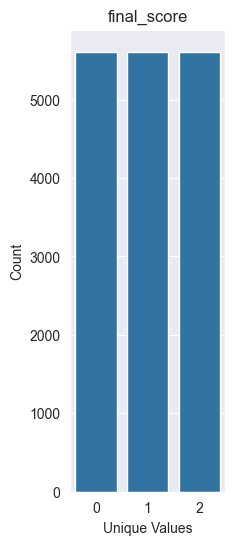

In [30]:
USE_SMOTE = False # Change this flag to True to use SMOTE.

# If I used smote I don't want to undersample to use a balanced dataset
use_balanced = not USE_SMOTE
if use_balanced:
    min_class_count = pd.Series.min(game_results_ready['final_score'].value_counts())  # The count of the smallest class
    # Create a balanced DataFrame by sampling from each class
    balanced_game_results = pd.DataFrame()
    # If a class has fewer instances than the smallest class, we'll need to sample with replacement
    for class_label in game_results_ready['final_score'].unique():
        class_subset = game_results_ready[game_results_ready['final_score'] == class_label]
        if len(class_subset) > min_class_count:
            # If we have more than the minimum class count, we sample without replacement
            class_subset_sample = class_subset.sample(n=min_class_count, random_state=42)
        else:
            # If not, we sample with replacement to boost up to the minimum class count
            class_subset_sample = class_subset.sample(n=min_class_count, random_state=42, replace=True)
        balanced_game_results = pd.concat([balanced_game_results, class_subset_sample], axis=0)
    
    # Update the game_results DataFrame to be the balanced one
    game_results_ready = balanced_game_results
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(2, 6))
sns.countplot(x='final_score', data=game_results_ready)
plt.title('final_score')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.show()

In [31]:
# Now, each class should have the same number of instances
game_results_ready['final_score'].value_counts()

final_score
1    5610
2    5610
0    5610
Name: count, dtype: int64

In [32]:
# Define the classes based on final_score
X = game_results_ready.drop(['final_score'], axis=1)
y = game_results_ready['final_score']
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16830 entries, 3621 to 12312
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   neutral                      16830 non-null  int64  
 1   home_code                    16830 non-null  int16  
 2   away_code                    16830 non-null  int16  
 3   hosting_country_code         16830 non-null  int64  
 4   tournament_code              16830 non-null  int64  
 5   most_recent_rank_home        16830 non-null  float64
 6   most_recent_rank_away        16830 non-null  float64
 7   most_recent_rank_difference  16830 non-null  float64
 8   home_advantage               16830 non-null  int64  
 9   home_fifa_pts                16830 non-null  float64
 10  away_fifa_pts                16830 non-null  float64
 11  head_to_head_last_5_home     16830 non-null  int64  
 12  head_to_head_last_5_away     16830 non-null  int64  
 13  scored_last_5_home

In [33]:
corr_mtx = game_results_ready.corr(numeric_only=True)
corr_mtx['final_score'].sort_values(ascending=False)

final_score                    1.000000
most_recent_rank_away          0.210981
home_advantage                 0.094003
home_fifa_pts                  0.085454
home_code                      0.041697
days_since_last_match_away     0.039010
hosting_country_code           0.014275
wins_last_10_games_home        0.010306
tournament_code                0.009907
goal_difference_last_5_home    0.005923
goal_difference_last_5_away    0.005110
wins_last_10_games_away        0.003537
scored_last_5_away             0.002350
scored_last_5_home             0.001436
head_to_head_last_5_away       0.000483
head_to_head_last_5_home      -0.000736
conceded_last_5_away          -0.005326
conceded_last_5_home          -0.008702
away_code                     -0.031356
days_since_last_match_home    -0.052441
neutral                       -0.094519
away_fifa_pts                 -0.138563
most_recent_rank_home         -0.205386
most_recent_rank_difference   -0.389226
Name: final_score, dtype: float64

In [34]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# 
# game_results_ready = game_results.drop(['home_team','away_team','home_score','away_score','tournament','country','date','match_id','home_match_id','away_match_id'],axis=1)
# X = game_results_ready.drop(['final_score'], axis=1)
# y = game_results_ready['final_score']
# 
# # Splitting of Data - 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, stratify=y,  random_state=42)
# svm = svm_ovo = SVC(decision_function_shape='ovo', kernel='linear')
# lr = LogisticRegression(multi_class='multinomial',random_state=42)
# svm_ovo.fit(X_train, y_train)
# lr.fit(X_train,y_train)
# y_pred_ovo = svm_ovo.predict(X_test)
# y_pred_lr = lr.predict(X_test)
# accuracy_ovo = accuracy_score(y_test, y_pred_ovo)
# accuracy_lr = accuracy_score(y_test, y_pred_lr)
# print(f"Accuracy (One-vs-One): {accuracy_ovo}")
# print(f"Accuracy (Logistic Regression): {accuracy_lr}")

### We have our X and y
We will not shuffle because we want our training to happen to the earlier games and our testing to happen to the later games.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Splitting of Data - 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,stratify=y,  random_state=42)
use_scaled_data = True
if use_scaled_data:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

### SMOTE-ing
Here we can choose to SMOTE or not..

In [36]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
#use_smote = False # Change this flag to True to use SMOTE.
if USE_SMOTE:
    kn = list(range(2,20,2))
    accuracies = []
    i=0
    while i<len(kn):
        smote = SMOTE(random_state=42,k_neighbors=kn[i],n_jobs=-1)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        from sklearn.ensemble import ExtraTreesClassifier  
        from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
        test_model = ExtraTreesClassifier(criterion='gini',warm_start=True,bootstrap=False,n_jobs=-1,max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=3, n_estimators= 400)
        test_model.fit(X_train_smote,y_train_smote)
        y_preds = test_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_preds)
        accuracies.append(accuracy)
        i+=1
    kn_accuracy = {kn[i]:accuracies[i] for i in range(len(kn))}
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(kn, accuracies, marker='o', linestyle='-', color='b')
    plt.title('Accuracy vs K-Neighbors')
    plt.xlabel('K-Neighbors')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 31, step=2))  # Adjust x-axis ticks as needed
    plt.yticks(np.arange(0.58, 0.61, step=0.01))  # Adjust y-axis ticks as needed
    plt.grid(True)
    plt.show()
    # Find best KN
    BEST_KN = max(kn_accuracy, key=kn_accuracy.get)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(2, 6))
sns.countplot(x=y_train_smote)
plt.title('final_score')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.show()

NameError: name 'y_train_smote' is not defined

<Figure size 200x600 with 0 Axes>

### Model Training Phase 

Multi-Class Model predicts for 3 outcomes : Home win, Home loss, and Tie


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier,RandomTreesEmbedding

from sklearn.pipeline import make_pipeline
# Create a RandomForestClassifier model with balanced class weights
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
main_model = make_pipeline(RandomTreesEmbedding(n_estimators=400,min_samples_leaf=5, random_state=42), ExtraTreesClassifier(n_jobs=-1,max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=3, n_estimators=400))

if USE_SMOTE:
    smote = SMOTE(random_state=42,k_neighbors=BEST_KN,n_jobs=-1)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    main_model.fit(X_train_smote,y_train_smote)
elif use_scaled_data:
    main_model.fit(X_train_scaled,y_train)
else:
    main_model.fit(X_train,y_train)
y_preds = main_model.predict(X_test_scaled) if use_scaled_data else main_model.predict(X_test)
conf_mat = confusion_matrix(y_test,y_preds)
accuracy = accuracy_score(y_test, y_preds)
print(f'Model: Random Trees Embedding -> Extra Trees Classifier\nAccuracy: {accuracy}')
print(classification_report(y_test, y_preds))
accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=main_model.classes_, yticklabels=main_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

```
Accuracy: 0.6813230342642107
              precision    recall  f1-score   support

           0       0.62      0.68      0.65      1683
           1       0.77      0.62      0.69      1683
           2       0.67      0.74      0.71      1683

    accuracy                           0.68      5049
   macro avg       0.69      0.68      0.68      5049
weighted avg       0.69      0.68      0.68      5049
```

### Comparison of Results
Results when using standard scaler for the features:
```
Accuracy: 0.6712220241632006
              precision    recall  f1-score   support

           0       0.64      0.63      0.64      1683
           1       0.69      0.64      0.67      1683
           2       0.69      0.73      0.71      1683

    accuracy                           0.67      5049
   macro avg       0.67      0.67      0.67      5049
weighted avg       0.67      0.67      0.67      5049
```
Dry run of dataset as it is, no resampling:
```
Model: Logistic Regression multi-class
Accuracy: 0.5905166312809625
              precision    recall  f1-score   support

           0       0.55      0.53      0.54      1969
           1       0.38      0.12      0.19      1683
           2       0.63      0.85      0.73      3413

    accuracy                           0.59      7065
   macro avg       0.52      0.50      0.49      7065
weighted avg       0.55      0.59      0.55      7065
```

Undersampled dataset with ExtraTreesClassifier:
```
Accuracy: 0.678748266983561
              precision    recall  f1-score   support

           0       0.62      0.67      0.64      1683
           1       0.76      0.62      0.68      1683
           2       0.67      0.74      0.71      1683

    accuracy                           0.68      5049
   macro avg       0.69      0.68      0.68      5049
weighted avg       0.69      0.68      0.68      5049
```

SMOTE oversample:
```
Accuracy: 0.5985845718329795
              precision    recall  f1-score   support

           0       0.54      0.55      0.54      1969
           1       0.40      0.27      0.32      1683
           2       0.69      0.79      0.74      3413

    accuracy                           0.60      7065
   macro avg       0.54      0.54      0.53      7065
weighted avg       0.58      0.60      0.58      7065
```
Undersampled dataset with BOOTSTRAP=TRUE
```
Accuracy: 0.6726084373143196
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1683
           1       0.70      0.65      0.67      1683
           2       0.69      0.73      0.71      1683

    accuracy                           0.67      5049
   macro avg       0.67      0.67      0.67      5049
weighted avg       0.67      0.67      0.67      5049
```

### Comparing to different models

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso, LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier
# Comparison
compare = True
if compare:
    models = {
        'SVM': SVC(decision_function_shape='ovo',random_state=42,kernel='rbf'),
        'Logistic_Multi': LogisticRegression(multi_class='multinomial',random_state=42,max_iter=100000),
        'Gradient Boosting Classifier (400 estimators)': GradientBoostingClassifier(n_estimators=400, random_state=42),
        # 'Bagging Classifier':BaggingClassifier(n_estimators=200, max_samples=1.0, max_features=0.8, random_state=42,bootstrap=False),
        # 'hard voting classifier (ExtraTrees+GBoost+RandomForest)': VotingClassifier(estimators=[
        # ('extra_trees', ExtraTreesClassifier(criterion='gini',max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=3, n_estimators=400)),
        # ('gradient_boosting', GradientBoostingClassifier(n_estimators=400, random_state=42)),
        # ('random_forest', RandomForestClassifier(n_estimators=100))], voting='hard'),
        # 'ExtraTrees with Entropy':ExtraTreesClassifier(n_estimators=400,criterion='entropy',warm_start=False,bootstrap=False),
        # 'Rotational_Forest': RotationForest(n_estimators=100),
        'Random Tree Embedding': make_pipeline(RandomTreesEmbedding(n_estimators=400,min_samples_leaf=5, random_state=42), ExtraTreesClassifier(criterion='gini',n_jobs=-1,max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=3, n_estimators=400)),
        # 'Random Subspace (Pasting)':BaggingClassifier(estimator=ExtraTreesClassifier(), n_estimators=400, max_samples=1.0, max_features=0.8, random_state=42,bootstrap=False)
    }
    models_preds = {key:0 for key in models.keys()}
    for model in models.keys():
        print(model)
        if USE_SMOTE:
            models[model].fit(X_train_smote,y_train_smote)
        elif use_scaled_data:
            models[model].fit(X_train_scaled,y_train)
        else:
            models[model].fit(X_train,y_train)
        y_pred = models[model].predict(X_test_scaled) if use_scaled_data else models[model].predict(X_test)
        print(f'done predicting {model}')
        models_preds[model] = y_pred

### Let's evaluate the models

In [ ]:
print('test')
if compare:
    from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
    models_mtxs =  {key:0 for key in models.keys()}
    for model in models_preds.keys():
        conf_mtx = confusion_matrix(y_test,models_preds[model])
        accuracy = accuracy_score(y_test, models_preds[model])
        print(f'Model: {model}\nAccuracy: {accuracy}')
        print(classification_report(y_test, models_preds[model]))
        models_mtxs[model] = conf_mtx

In [ ]:
if compare:
    import seaborn as sns
    import matplotlib.pyplot as plt
    for mtx in models_mtxs.keys():
        sns.heatmap(models_mtxs[mtx], annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {mtx}')
        plt.show()

# Application of the Predictive Model

Match creator function to set up a match row between two teams. By default the game is played "today", so all the values for head_to_head and previous matches are relative to the match date.

In [38]:
# tournament code 0 as default -> Tournament
def match_creator(team_1,team_2,tournament_code=0):
    # Get home and away codes
    home_code,away_code = country_codes[team_1],country_codes[team_2]
    # Randomize if game is played at neutral ground
    neutral = random.randint(0,1)
    # if not on neutral ground, pick either home or away as playing ground. Else pick a random ground
    hosting_country_code = random.choice([home_code,away_code]) if not neutral else random.choice(list(country_codes.values()))
    # Get most recent rank for home
    most_recent_rank_home = rank_at_year_df.loc[team_1,datetime.now().year]
    # Get most recent rank for away
    most_recent_rank_away = rank_at_year_df.loc[team_2,datetime.now().year]
    most_recent_rank_difference = most_recent_rank_home-most_recent_rank_away
    home_advantage = (country_codes[team_1] == hosting_country_code)
    game_info = {
        'home_team':team_1,
        'away_team':team_2,
        'date':datetime.now()
    }
    head_to_head_last_5_home,head_to_head_last_5_away = calculate_head_to_head(game_info)
    goal_difference_last_5_home = calculate_goal_difference_last_5(game_info,'home_team')
    goal_difference_last_5_away = calculate_goal_difference_last_5(game_info,'away_team')
    days_since_last_match_home:pd.Series = (datetime.now() - game_results.loc[game_results['home_team'] == team_1].tail(1)['date']).to_list()[0].days
    days_since_last_match_away = (datetime.now() - game_results.loc[game_results['away_team'] == team_2].tail(1)['date']).to_list()[0].days
    wins_last_10_games_home = game_results.loc[(game_results['home_team'] == team_1)]['final_score'].eq(2).sum() + game_results.loc[(game_results['away_team'] == team_1)]['final_score'].eq(0).sum()
    wins_last_10_games_away = game_results.loc[(game_results['home_team'] == team_2)]['final_score'].eq(2).sum() + game_results.loc[(game_results['away_team'] == team_2)]['final_score'].eq(0).sum()
    home_fifa_pts = rank_at_year_df.loc[team_1,'{}_points'.format(datetime.now().year)]
    away_fifa_pts = rank_at_year_df.loc[team_2,'{}_points'.format(datetime.now().year)]
    scored_last_5_home =  game_results.loc[(game_results['home_team'] == team_1)].tail(5)['home_score'].sum() + game_results.loc[(game_results['away_team'] == team_1)].tail(5)['away_score'].sum()
    scored_last_5_away = game_results.loc[(game_results['home_team'] == team_2)].tail(5)['home_score'].sum() + game_results.loc[(game_results['away_team'] == team_2)].tail(5)['away_score'].sum()
    
    conceded_last_5_home = game_results.loc[(game_results['home_team'] == team_1)].tail(5)['away_score'].sum() + game_results.loc[(game_results['away_team'] == team_1)].tail(5)['home_score'].sum()
    
    conceded_last_5_away = game_results.loc[(game_results['home_team'] == team_2)].tail(5)['away_score'].sum() + game_results.loc[(game_results['away_team'] == team_2)].tail(5)['home_score'].sum()
    match_data = {
        'neutral': neutral,
        'home_code':home_code,
        'away_code':away_code,
        'hosting_country_code':hosting_country_code,
        'tournament_code':tournament_code,
        'most_recent_rank_home':most_recent_rank_home,
        'most_recent_rank_away':most_recent_rank_away,
        'most_recent_rank_difference':most_recent_rank_difference,
        'home_advantage':home_advantage,
        'home_fifa_pts':home_fifa_pts,
        'away_fifa_pts':away_fifa_pts,
        'head_to_head_last_5_home':head_to_head_last_5_home,
        'head_to_head_last_5_away':head_to_head_last_5_away,
        'goal_difference_last_5_home':goal_difference_last_5_home,
        'goal_difference_last_5_away':goal_difference_last_5_away,
        'days_since_last_match_home':days_since_last_match_home,
        'days_since_last_match_away':days_since_last_match_away,
        'scored_last_5_home':scored_last_5_home,
        'scored_last_5_away':scored_last_5_away,
        'conceded_last_5_home':conceded_last_5_home,
        'conceded_last_5_away':conceded_last_5_away, 
        'wins_last_10_games_home':wins_last_10_games_home,
        'wins_last_10_games_away':wins_last_10_games_away
    }
    match_idx = match_data.keys()
    return pd.Series(data=match_data.values(),index=match_idx).values.reshape(1,-1)

### USA vs Saudi Arabia

In [39]:
team_1, team_2 = 'Nigeria','Saudi Arabia'
my_match = match_creator(team_1, team_2)

KeyError: 2024

In [40]:
team_1 if main_model.predict(my_match) == 2 else team_2

NameError: name 'main_model' is not defined

### Let's run our own little tournament!
Predetermined countries in the tournament.

In [41]:
countries_to_match = ['Belgium','United States','Japan','Qatar','Saudi Arabia','England','Scotland','France','Brazil','Italy','Germany','Uruguay','Argentina','Spain','Mexico','Australia'] 

import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

def run_tournament(teams,tournament_type='cup',hosting_country='random',with_print=True):
    if not teams:
        return 
    # Randomize teams
    random.shuffle(teams)
    # If tournament_type is 'cup' then draws are not allowed. One team must win!
    tab=''
    # Match the teams until we have one team left
    while len(teams) != 1:
        winners = []
        # step of 2 to use 2 teams
        for i in range(0,len(teams),2):
            match = match_creator(teams[i],teams[i+1])
            if hosting_country != 'random':
                match = change_host(match,hosting_country,teams,i)
            # When we are at the final
            if len(teams) == 2: tab+='Final:'
            if with_print: print(tab,teams[i],'vs',teams[i+1],end=' -> ')
            # Initial prediction
            pred = main_model.predict(match)
            # If predicting a tie and it's a cup game, keep playing
            if pred == 1 and tournament_type == 'cup':
                if with_print: print('Tie at full time. Playing extra-time.',end=' -> ')
                match = match_creator(teams[i],teams[i+1],tournament_code=1) # Make the game more serious by
                if hosting_country != 'random': match = change_host(match,hosting_country,teams,i)
                pred = main_model.predict(match)
                # If tie again, keep going
                if pred == 1:
                    if with_print: print('Tie at extra time. Playing penalty shoot-outs.',end=' -> ')
                    match = match_creator(teams[i],teams[i+1],tournament_code=1)
                    if hosting_country != 'random': match = change_host(match,hosting_country,teams,i)
                    pred = main_model.predict(match)
                    # If another tie -> go to penalties. At this point it's just random, just like the outcome of a penalty shootout!
                    if pred == 1:
                        # Penalties are random anyway!
                        winner = teams[i] if random.randint(0,99) % 2 == 0 else teams[i+1]
                    else:
                        winner = teams[i] if pred == 2 else teams[i+1]
                    if with_print: print(winner,'won after penalty shoot-outs!')
                else:
                    winner = teams[i] if pred == 2 else teams[i+1]
                    if with_print: print(winner,'won after extra time.')
            else:
                winner = teams[i] if pred == 2 else teams[i+1]
                if with_print: print(winner,'won after full time.')
            winners.append(winner)
        # Clear the teams
        teams.clear()
        teams = winners
        tab+='\t'
    return teams[0]
# Quick and dirty
def change_host(match,host,teams,i):
    match[0][3] = country_codes[host]
    match[0][0] = (match[0][3] != teams[i]) and (match[0][3] != teams[i+1])
    match[0][8] = match[0][3] == teams[i]
    return match
run_tournament(countries_to_match)

KeyError: 2024

## Gets k countries randomly

In [816]:
def get_valid_countries(k):
    # We need evens only
    if k % 2 == 1:
        k += 1
    all_countries = list(rank_at_year_df.index.values)
    # For some reason these countries cause issues
    all_countries.remove('Yugoslavia')
    all_countries.remove('Serbia and Montenegro')
    all_countries.remove('Czechoslovakia')
    all_countries.remove('Netherlands Antilles')
    valid_countries = set()
    while len(valid_countries) != k:
        curr_country = random.choice(all_countries)
        val = country_codes.setdefault(curr_country,-1)
        if val != -1: valid_countries.add(curr_country)
    return list(valid_countries)

### Let's generate random countries and create a 64-team tournament

In [817]:
my_tournament = get_valid_countries(64)
country_ranks = {country:rank_at_year_df.loc[country,int(datetime.now().year)] for country in my_tournament}
best_rank = min(country_ranks.values())
best_country = list(filter(lambda x: country_ranks[x] == best_rank,country_ranks.keys()))[0]
avg_rank = sum(country_ranks.values())/len(country_ranks.values())
print('Best country: {} - Ranked {}\nAverage Team Rank: {}'.format(best_country,best_rank,avg_rank))

Best country: England - Ranked 5.0
Average Team Rank: 113.890625


In [818]:
# Designate a country to host the tournament
host = 'England'
winner = run_tournament(my_tournament,hosting_country=host,with_print=True)
print(winner,'wins the tournament!')
if winner != best_country:
    print('What a great tournament!')
else:
    print('The best team won, as expected.')
print('Tournament hosted by',host)

 Chile vs Saudi Arabia -> Tie at full time. Playing extra-time. -> Tie at extra time. Playing penalty shoot-outs. -> Saudi Arabia won after penalty shoot-outs!
 Laos vs Pakistan -> Pakistan won after full time.
 Bhutan vs Burkina Faso -> Burkina Faso won after full time.
 Algeria vs Guinea -> Tie at full time. Playing extra-time. -> Guinea won after extra time.
 Tunisia vs England -> England won after full time.
 Madagascar vs Republic of Ireland -> Republic of Ireland won after full time.
 Turkey vs Faroe Islands -> Turkey won after full time.
 Benin vs Libya -> Tie at full time. Playing extra-time. -> Tie at extra time. Playing penalty shoot-outs. -> Libya won after penalty shoot-outs!
 New Zealand vs Burundi -> Tie at full time. Playing extra-time. -> Tie at extra time. Playing penalty shoot-outs. -> Burundi won after penalty shoot-outs!
 Zimbabwe vs United States -> United States won after full time.
 Kuwait vs Senegal -> Senegal won after full time.
 Sierra Leone vs Curaçao -> Cur

In [819]:
i = 0
WC_wins = dict()
# Number of runs to run statistics on
runs = 0
num_teams = 32
host='England'
while i != runs:
    world_cup = get_valid_countries(num_teams)
    country_ranks = {country:rank_at_year_df.loc[country,2023] for country in world_cup}
    best_rank = min(country_ranks.values())
    best_country = list(filter(lambda x: country_ranks[x] == best_rank,country_ranks.keys()))[0]
    print('run {} - Highest ranked team: {} Rank {}'.format(i,best_country,best_rank))
    winner = run_tournament(teams=world_cup,hosting_country=host,with_print=False)
    WC_wins[winner] = (WC_wins.get(winner,0) + 1)
    i+=1
stats = dict()
for winner in WC_wins.keys():
    stats[winner] = WC_wins.get(winner)/runs
display(stats)

{}

In [820]:
print('test')
sorted_dict = sorted(WC_wins.items(), key=lambda x:x[1])
for winner in sorted_dict[-10:]:
    rank = rank_at_year_df.loc[winner[0],2023]
    print(f'Team: {winner[0]:<20} Win%: {winner[1]:<2}% {" "*3:<10}FIFA Ranking 2023: {rank:<15}')

test


## Optimization part
Used GridSearch to find the best params for the extra trees

In [821]:
perform_gridsearch = False

if perform_gridsearch:
    from sklearn.metrics import make_scorer, precision_score
    from sklearn.model_selection import GridSearchCV
    import warnings
    
    # Suppress the ANNOYING FutureWarning messages
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=UserWarning)
    
    param_grid = {
        'base_estimator__n_estimators': [50, 100, 200,300,400],
        'base_estimator__max_depth': [None, 10, 20],
        'max_samples': [0.8, 1.0],
        'max_features': [0.8, 1.0]
    }
    # Create a Random Subspace Classifier pipeline
    random_subspace_model = BaggingClassifier(base_estimator=ExtraTreesClassifier(random_state=42), random_state=42)
    scorer = make_scorer(precision_score, average='macro')
    grid_search = GridSearchCV(estimator=random_subspace_model, param_grid=param_grid, cv=5, scoring=scorer, n_jobs=-1)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and corresponding precision score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Precision Score:", grid_search.best_score_)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on the test set
    y_pred = best_model.predict(X_test)

```
Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 400}
Best Precision Score: 0.6496295887336865

Best Parameters: {'base_estimator__max_depth': None, 'base_estimator__n_estimators': 50, 'max_features': 0.8, 'max_samples': 1.0}
Best Precision Score: 0.6331092403002385
```